## 1. Data Loading and Conversion

In [ ]:
import numpy as np
x = np.load('./BASC-444_tangent_correlation.npy') 
y = np.load('./Y.npy')  # Assuming shape: (871,)

print(x.shape)
print(y.shape)

## 2. Graph Arrangement

In [ ]:
num_graphs, num_nodes, _ = x.shape
print(x.shape)
num_features = num_nodes * (num_nodes - 1) // 2   

print("num_graphs:", num_graphs)   
print("num_nodes:", num_nodes)    
print("num_features:", num_features)  

# List mapping each “feature index” [0..E]  to an (i,j) pair in the upper triangle
edge_pairs = [(i, j) for i in range(num_nodes) for j in range(i + 1, num_nodes)]

## 3. Parameters for trials and selection

In [ ]:
num_selected = int(0.20 * num_features)  # 20% of
num_trials = 500  # number of repetitions.( I reduced for now due to how long it will take)
num_epochs = 30  # number of training epochs per trial. ( reduced for same reason)

# Create arrays to store each trial's selected indices and accuracy.
# The indices array is shaped as (num_selected, num_trials), where each column represents one trial.
indices_matrix = np.zeros((num_selected, num_trials), dtype=int)
accuracy_vector = np.zeros(num_trials)

## 4. Generate Graph Function

In [ ]:
import torch
from torch_geometric.data import Data

def generate_multiple_graphs(X, y):
    """
    Generate multiple PyTorch Geometric graph objects from full symmetric adjacency matrices.
    
    Parameters:
        X (numpy.ndarray): 3D array of shape (num_graphs, N_nodes, N_nodes) where each entry is an adjacency matrix.
        y (numpy.ndarray): 1D array of graph labels.
    
    Returns:
        List[Data]: A list of PyTorch Geometric Data objects.
    """
    graphs = []
    num_graphs = X.shape[0]
    N_nodes = X.shape[1] # Assuming square adjacency matrices

    for graph_idx in range(num_graphs):
        adjacency_matrix = X[graph_idx]
        label = y[graph_idx]

        # Initialize node features,edge index and weight.
        node_features = [[1,] for _ in range(N_nodes)]
        edge_index = []
        edge_weight = []

        # Iterate over upper triangle to avoid self-loops and duplicate edges
        for i in range(N_nodes):
            for j in range(i + 1, N_nodes): # Avoiding self-loops and duplicate edges
                weight = adjacency_matrix[i, j]
                if weight != 0: # Only include edges with non-zero weight
                    # Add both (i, j) and (j, i) for undirected graph
                    edge_index.append([i, j])
                    edge_weight.append(weight) # I removed the additional edge_index since the graph is undirected. 
                                       
                    # Update node features by accumulating connected edge weights
                    node_features[i][0] += weight
                    node_features[j][0] += weight

        # Convert lists to PyTorch tensors
        if edge_index:
            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
            edge_weight = torch.tensor(edge_weight, dtype=torch.float)
        else:
            edge_index = torch.empty((2, 0), dtype=torch.long)
            edge_weight = torch.tensor([], dtype=torch.float)
        node_features = torch.tensor(node_features, dtype=torch.float)
        label_tensor = torch.tensor(label, dtype=torch.float)

        data = Data(x=node_features, edge_index=edge_index, edge_weight=edge_weight, y=label_tensor)
        graphs.append(data)
                     
    return graphs

## 5. GNN Model

In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, global_mean_pool

class GraphAttentionModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=4):
        super(GraphAttentionModel, self).__init__()
        # 1st GATv2 layer: input_dim → hidden_dim, using 'heads' attention heads
        # edge_dim=1 since each edge has one feature (FC weight)
        self.gat1 = GATv2Conv(
            in_channels=input_dim,
            out_channels=hidden_dim,
            heads=heads,
            dropout=0.3,
            edge_dim=1
        )
        # 2nd GATv2 layer: (hidden_dim * heads) → hidden_dim
        self.gat2 = GATv2Conv(
            in_channels=hidden_dim * heads,
            out_channels=hidden_dim,
            heads=heads,
            dropout=0.3,
            edge_dim=1
        )
        # 3rd GATv2 layer: (hidden_dim * heads) → output_dim, single head, no concat
        self.gat3 = GATv2Conv(
            in_channels=hidden_dim * heads,
            out_channels=output_dim,
            heads=1,
            concat=False,
            dropout=0.3,
            edge_dim=1
        )
        # Final linear layer for binary classification
        self.fc = torch.nn.Linear(output_dim, 1)

    def forward(self, x, edge_index, edge_weight, batch):
        # Reshape edge_weight from (E,) → (E, 1)
        ew = edge_weight.view(-1, 1)

        # 1) Apply first GATv2 + ReLU
        x = F.relu(self.gat1(x, edge_index, ew))
        # 2) Apply second GATv2 + ReLU
        x = F.relu(self.gat2(x, edge_index, ew))
        # 3) Apply third GATv2 (no activation)
        x = self.gat3(x, edge_index, ew)
        # 4) Global mean pool over nodes → one graph vector
        x = global_mean_pool(x, batch)
        # 5) Linear layer + sigmoid for binary output
        x = self.fc(x)
        return torch.sigmoid(x)

## 6. Training and Evaluation Functions 

In [ ]:
def train(model, loader, optimizer, criterion):
    # Train the model for one epoch over the given data loader
    model.train()
    total_loss = 0

    for data in loader:
        optimizer.zero_grad()
        # Forward pass
        out = model(data.x, data.edge_index, data.edge_weight, data.batch)
        # Compute loss (reshape output to match labels)
        loss = criterion(out.squeeze(1), data.y.float())
        # Backward pass and weight update
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Return the average loss per batch
    return total_loss / len(loader)


def evaluate(model, loader):
    # Compute overall accuracy of the model on the provided data loader
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in loader:
            # Forward pass
            out = model(data.x, data.edge_index, data.edge_weight, data.batch)
            # Convert probabilities to binary predictions (threshold = 0.5)
            pred = (out.squeeze(1) > 0.5).float()
            correct += (pred == data.y).sum().item()
            total += data.num_graphs

    # Return the fraction of correctly classified graphs
    return correct / total


def eval_loss(model, loader, criterion):
    # Compute the average loss of the model over all graphs in the loader
    model.eval()
    total_loss = 0.0
    total_graphs = 0

    with torch.no_grad():
        for data in loader:
            # Forward pass
            out = model(data.x, data.edge_index, data.edge_weight, data.batch)
            # Compute loss for this batch, weighted by number of graphs
            loss = criterion(out.squeeze(1), data.y.float())
            total_loss += loss.item() * data.num_graphs
            total_graphs += data.num_graphs

    # Return the average loss per graph
    return total_loss / total_graphs

## 7. Main Loop: Trails of random column removal, train/test split and graph generation/classiication

In [ ]:
from torch_geometric.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import random_split

for trial in range(num_trials):
    print(f"Trial {trial+1}/{num_trials}")

    # 1) Randomly select 20% of the ? upper‐triangle “features” (each maps to one (i,j) pair)
    selected_feat_idxs = np.random.choice(num_features, size=num_selected, replace=False)
    indices_matrix[:, trial] = selected_feat_idxs  # Save selected indices for this trial

    # 2) Create a modified copy of the full (871, E, E) FC matrices
    X_mod = x.copy()  # x.shape 

    #    Zero out each chosen edge (i,j) and its mirror (j,i) across all subjects
    for feat_idx in selected_feat_idxs:
        i, j = edge_pairs[feat_idx]
        X_mod[:, i, j] = 0.0
        X_mod[:, j, i] = 0.0

    # 3) Generate PyG graphs from the masked FC matrices
    graphs = generate_multiple_graphs(X_mod, y)

    # 4) Split graphs into train/val/test (80/10/10)
    dataset_size = len(graphs)
    train_size   = int(0.8 * dataset_size)
    val_size     = int(0.1 * dataset_size)
    test_size    = dataset_size - train_size - val_size
    train_data, val_data, test_data = random_split(graphs, [train_size, val_size, test_size])

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
    val_loader   = DataLoader(val_data,   batch_size=32)
    test_loader  = DataLoader(test_data,  batch_size=32)

    # 5) Initialize model, loss, optimizer, and scheduler 
    model     = GraphAttentionModel(input_dim=1, hidden_dim=16, output_dim=2)
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # 6) Training loop 
    best_val_loss    = float('inf')
    best_model_state = None
    wait             = 0
    patience         = 10

    for epoch in range(1, num_epochs + 1):
        train_loss = train(model, train_loader, optimizer, criterion)
        val_loss   = eval_loss(model, val_loader, criterion)
        val_acc    = evaluate(model, val_loader)
        scheduler.step(val_loss)

        print(f"Epoch {epoch:02d} — Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss    = val_loss
            best_model_state = model.state_dict()
            wait             = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"--> Early stopping at epoch {epoch} (no val_loss improvement in {patience} epochs)")
                break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # 7) Test‐set evaluation
    test_acc = evaluate(model, test_loader)
    accuracy_vector[trial] = test_acc
    print(f"Trial {trial+1} Test Acc: {test_acc:.4f}")

# 8. Saving recall indices/accuracy as npy.files

In [ ]:
np.save('selected_indices_basc444(500t-tang).npy', indices_matrix)# Showcase each column(trial) of indices that were zeroed out. 
np.save('accuracy_vector_basc444(500t-tang).npy', accuracy_vector) # Showcase test accuracy for each trial. 500 trials=500 entries. 

print("Processing complete. The selected indices and accuracy vector have been saved.")

In [2]:
import numpy as np
selected_indices = np.load('./data2/selected_indices_basc444(500t-tangent).npy')
accuracy_vector = np.load('./data2/accuracy_vector_basc444(500t-tangent).npy')

mean_acc = np.mean(accuracy_vector)
print("Mean accuracy across trials:", mean_acc)

Mean accuracy across trials: 0.5401818181818181


# 9. Post-hockey Analysis ( Determing Influence)

In [ ]:
# Transpose indices_matrix so each row corresponds to one trial
indices_matrix_transposed = indices_matrix.T  # Shape: (num_trials, num_selected)

# Compute median accuracy across all trials
median_acc = np.median(accuracy_vector)
print("Median accuracy across trials:", median_acc)

# Split trials into “good” (>= median) and “bad” (< median)
good_trials = indices_matrix_transposed[accuracy_vector >= median_acc]
bad_trials  = indices_matrix_transposed[accuracy_vector <  median_acc]

# Flatten the selected indices for each category
good_indices = good_trials.flatten() if good_trials.size > 0 else np.array([])
bad_indices  = bad_trials.flatten()  if bad_trials.size  > 0 else np.array([])

# Count how often each of the num_features indices was chosen
freq_good = np.bincount(good_indices, minlength=num_features)
freq_bad  = np.bincount(bad_indices,  minlength=num_features)

# Extract the top 50 most frequent indices in each category
top_k = 50
top_good_idx = np.argsort(freq_good)[-top_k:][::-1]
top_bad_idx  = np.argsort(freq_bad)[-top_k:][::-1]

print("\nTop 50 indices for good trials and their frequencies:")
for idx in top_good_idx:
    print(f"Index {idx}: {freq_good[idx]} occurrences")

print("\nTop 50 indices for bad trials and their frequencies:")
for idx in top_bad_idx:
    print(f"Index {idx}: {freq_bad[idx]} occurrences")


## 10. Preview Saved Files

In [ ]:
accuracy_vector = np.load('accuracy_vector_basc444(500t-tang).npy') # when you have required file from custom path
print(accuracy_vector)

In [ ]:
selected_indices = np.load('selected_indices_basc444(500t-tang).npy') # when you have required file from custom path
import pandas as pd
df = pd.DataFrame(selected_indices)
print(df)

In [ ]:
!pip install nilearn
!pip install --upgrade nilearn
from nilearn.datasets import fetch_atlas_basc_multiscale_2015

## 11. Nilearn Visulization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn.datasets import fetch_atlas_basc_multiscale_2015
from nilearn import plotting

# Parameters for BASC444
num_nodes    = 444
num_features = num_nodes * (num_nodes - 1) // 2  
top_k        = 20  # how many top edges to show

# Load the selected edge indices and accuracy per trial
selected_indices = np.load('selected_indices_basc444(500t-tang).npy')  # (num_selected, num_trials)
accuracy_vector  = np.load('accuracy_vector_basc444(500t-tang).npy')   # (num_trials,)

# Find all trials where accuracy is below the median (bad trials) as well as the bad indices
indices_matrix = selected_indices.T  # shape: (num_trials, num_selected)
median_acc     = np.median(accuracy_vector)
bad_trials     = indices_matrix[accuracy_vector < median_acc]
bad_indices    = bad_trials.flatten() if bad_trials.size > 0 else np.array([], dtype=int)

# Count how often each edge appears in bad trials
freq_bad = np.bincount(bad_indices, minlength=num_features)

# Pick the top_k edges that appear most often in bad trials
top_bad_idx = np.argsort(freq_bad)[-top_k:][::-1]

# Helper to convert a flat edge index k to (i,j) in a n*n matrix
def index_to_coords(k, n=num_nodes):
    total = 0
    for i in range(n - 1):
        count = n - i - 1
        if k < total + count:
            j = i + 1 + (k - total)
            return i, j
        total += count
    raise ValueError("Index out of range.")

# Build a symmetric “frequency” matrix for those critical edges
matrix_critical = np.zeros((num_nodes, num_nodes))
for idx in top_bad_idx:
    i, j = index_to_coords(int(idx))
    matrix_critical[i, j] = freq_bad[idx]
    matrix_critical[j, i] = freq_bad[idx]

# Fetch AAL centroids for plotting
basc = fetch_atlas_basc_multiscale_2015()           
coords = plotting.find_parcellation_cut_coords(basc.scale444)  

# Plot only those critical connections on a glass brain
threshold = freq_bad[top_bad_idx[-1]]  # lowest frequency among the chosen edges
display = plotting.plot_connectome(
    matrix_critical,
    coords,
    edge_threshold=threshold,
    node_size=10,
    title=f"Top {top_k} Critical Connections (Bad Trials) — BASC444"
)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn.datasets import fetch_atlas_basc_multiscale_2015
from nilearn import plotting

# Parameters for BASC444
num_nodes    = 444
num_features = num_nodes * (num_nodes - 1) // 2  
top_k        = 20      # edges per category

# Load trial data
selected_indices = np.load('selected_indices_basc444(500t-tang).npy')  # shape: (num_selected, num_trials)
accuracy_vector  = np.load('accuracy_vector_basc444(500t-tang).npy')   # shape: (num_trials,)

# Prepare split by median accuracy
indices_matrix = selected_indices.T                 # (num_trials, num_selected)
median_acc     = np.median(accuracy_vector)

# Bad trials / critical edges
bad_trials     = accuracy_vector < median_acc
bad_indices  = indices_matrix[bad_trials].flatten() if bad_trials.any() else np.array([], dtype=int)
freq_bad     = np.bincount(bad_indices, minlength=num_features)
top_bad_idx  = np.argsort(freq_bad)[-top_k:][::-1]

# Good trials / redundant edges
good_trials     = accuracy_vector >= median_acc
good_indices  = indices_matrix[good_trials].flatten() if good_trials.any() else np.array([], dtype=int)
freq_good     = np.bincount(good_indices, minlength=num_features)
top_good_idx  = np.argsort(freq_good)[-top_k:][::-1]

# Index→(i,j) helper for upper‐triangle of an n×n matrix
def index_to_coords(k, n=num_nodes):
    tot = 0
    for i in range(n - 1):
        cnt = n - i - 1
        if k < tot + cnt:
            return i, i + 1 + (k - tot)
        tot += cnt
    raise ValueError(f"Index {k} out of range")

# Plotting helper
def plot_edges(edge_idx_list, freq_arr, title):
    # build full symmetric weight matrix
    M = np.zeros((num_nodes, num_nodes))
    connected = np.zeros(num_nodes, bool)
    for k in edge_idx_list:
        i, j = index_to_coords(int(k))
        M[i, j] = freq_arr[k]
        M[j, i] = freq_arr[k]
        connected[[i, j]] = True

    # node styling
    node_sizes  = [20 if c else 10 for c in connected]
    node_colors = ['blue' if c else 'darkgray' for c in connected]

    # fetch BASC444 centroids
    basc = fetch_atlas_basc_multiscale_2015()
    coords = plotting.find_parcellation_cut_coords(basc.scale444)

    # edge threshold = smallest of the top‐K freqs
    thresh = float(freq_arr[edge_idx_list[-1]])
    plotting.plot_connectome(
        M, coords,
        edge_threshold=thresh,
        node_size=node_sizes,
        node_color=node_colors,
        title=title
    )
    plt.show()

# Visualize both panels
plot_edges(top_bad_idx,  freq_bad,  f"Top {top_k} Critical Connections (Bad Trials)")
plot_edges(top_good_idx, freq_good, f"Top {top_k} Redundant Connections (Good Trials)")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn.datasets import fetch_atlas_basc_multiscale_2015
from nilearn import plotting

# Parameters for BASC444
num_nodes    = 444
num_features = num_nodes * (num_nodes - 1) // 2  
top_k        = 20

# Load trial data
selected_indices = np.load('selected_indices_basc444(500t-tang).npy')  # (num_selected, num_trials)
accuracy_vector  = np.load('accuracy_vector_basc444(500t-tang).npy')   # (num_trials,)

# Prepare median split
indices_matrix = selected_indices.T                 # (num_trials, num_selected)
median_acc     = np.median(accuracy_vector)

bad_trials  = indices_matrix[accuracy_vector < median_acc]
bad_indices = bad_trials.flatten() if bad_trials.size > 0 else np.array([], dtype=int)
freq_bad    = np.bincount(bad_indices, minlength=num_features)
top_bad_idx = np.argsort(freq_bad)[-top_k:][::-1]

good_trials  = indices_matrix[accuracy_vector >= median_acc]
good_indices = good_trials.flatten() if good_trials.size > 0 else np.array([], dtype=int)
freq_good    = np.bincount(good_indices, minlength=num_features)
top_good_idx = np.argsort(freq_good)[-top_k:][::-1]

#  Map 1D edge-index → (i, j) in the n×n matrix 
def index_to_coords(k, n=num_nodes):
    total = 0
    for i in range(n - 1):
        count = n - i - 1
        if k < total + count:
            return i, i + 1 + (k - total)
        total += count
    raise ValueError(f"Index {k} out of range for n={n}.")

# Plot nodes on ortho slices centered on their centroid
def plot_nodes_ortho(edge_idx_list, title):
    # 1. Flag which nodes are involved
    connected = np.zeros(num_nodes, dtype=bool)
    for idx in edge_idx_list:
        i, j = index_to_coords(int(idx))
        connected[i] = True
        connected[j] = True

    # 2. Fetch BASC444 centroids
    basc   = fetch_atlas_basc_multiscale_2015()
    coords = plotting.find_parcellation_cut_coords(basc.scale444)

    # 3. Extract only the active-node coords
    coords_active = np.array([coords[i] for i, flag in enumerate(connected) if flag])
    if coords_active.size == 0:
        print(f"No nodes to plot for: {title}")
        return

    # 4. Compute mean center
    center = tuple(coords_active.mean(axis=0))

    # 5. Plot the anatomical slices
    display = plotting.plot_anat(
        title=title,
        display_mode='ortho',
        cut_coords=center
    )

    # 6. Overlay markers at each active centroid
    display.add_markers(
        coords_active.tolist(),
        marker_color='blue',
        marker_size=50
    )
    plt.show()

# Visualize critical vs. redundant nodes
plot_nodes_ortho(top_bad_idx,  f"Top {top_k} Critical Nodes (Bad Trials)")
plot_nodes_ortho(top_good_idx, f"Top {top_k} Redundant Nodes (Good Trials)")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn.datasets import fetch_atlas_basc_multiscale_2015
from nilearn import plotting

# Load your trial data 
selected_indices = np.load('selected_indices_basc444(500t-tang).npy')  # shape: (num_selected, num_trials)
accuracy_vector  = np.load('accuracy_vector_basc444(500t-tang).npy')   # shape: (num_trials,)

# Parameters for BASC444
num_nodes    = 444
num_features = num_nodes * (num_nodes - 1) // 2  
top_k        = 20

#  Split by median accuracy
median_acc = np.median(accuracy_vector)
all_trials = np.arange(len(accuracy_vector))

bad_trials  = accuracy_vector < median_acc
good_trials = accuracy_vector >= median_acc

# Identify the single worst (lowest‐acc) bad trial and best (highest‐acc) good trial
bad_trials = all_trials[bad_trials]
best_bad   = bad_trials[np.argmin(accuracy_vector[bad_trials])] if bad_trials.size else None

good_trials = all_trials[good_trials]
best_good   = good_trials[np.argmax(accuracy_vector[good_trials])] if good_trials.size else None

# Precompute global edge frequencies over bad vs. good sets
indices_matrix = selected_indices.T  # (num_trials, num_selected)
freq_bad  = np.bincount(indices_matrix[bad_trials].flatten(),  minlength=num_features)
freq_good = np.bincount(indices_matrix[good_trials].flatten(), minlength=num_features)

# Helper: map 1D edge‐index → (i,j) in the upper triangle of an n×n matrix
def index_to_coords(k, n=num_nodes):
    total = 0
    for i in range(n - 1):
        cnt = n - i - 1
        if k < total + cnt:
            return i, i + 1 + (k - total)
        total += cnt
    raise ValueError(f"Index {k} out of range for n={n}")

# Fetch BASC444 centroids once
basc    = fetch_atlas_basc_multiscale_2015()
coords  = plotting.find_parcellation_cut_coords(basc.scale444)

def plot_top20(trial_idx, freq_array, label):
    if trial_idx is None:
        print(f"No {label} trials to plot.")
        return

    acc    = accuracy_vector[trial_idx]
    masked = selected_indices[:, trial_idx]   # which edges were zeroed in that trial

    # rank those edges by their overall freq, take top_k
    ranked = masked[np.argsort(freq_array[masked])[::-1]]
    top20   = ranked[:top_k]

    # build n×n adjacency with only those edges
    M = np.zeros((num_nodes, num_nodes))
    involved = np.zeros(num_nodes, bool)
    for k in top20:
        i, j = index_to_coords(int(k))
        M[i, j] = freq_array[int(k)]
        M[j, i] = freq_array[int(k)]
        involved[i] = True
        involved[j] = True

    # style nodes
    sizes  = [30 if involved[n] else 10 for n in range(num_nodes)]
    colors = ['blue' if involved[n] else 'darkgray' for n in range(num_nodes)]

    plotting.plot_connectome(
        M,
        coords,
        edge_threshold=min(freq_array[top20]),
        node_size=sizes,
        node_color=colors,
        title=f"{label} Trial #{trial_idx} — Acc={acc:.3f}"
    )
    plt.show()

# Plot the two panels
plot_top20(best_bad,  freq_bad,  "Worst-Bad (Critical Edges)")
plot_top20(best_good, freq_good, "Best-Good (Non-critical Edges)")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn.datasets import fetch_atlas_basc_multiscale_2015
from nilearn import plotting

# Load your trial data
selected_indices = np.load('selected_indices_basc444(500t-tang).npy')  # (num_selected, num_trials)
accuracy_vector  = np.load('accuracy_vector_basc444(500t-tang).npy')   # (num_trials,)

# Parameters for BASC444
num_nodes    = 444
num_features = num_nodes * (num_nodes - 1) // 2   
top_k        = 20

# Split by median accuracy
median_acc = np.median(accuracy_vector)
all_trials = np.arange(len(accuracy_vector))

bad_trials  = accuracy_vector < median_acc
good_trials = accuracy_vector >= median_acc

bad_trials  = all_trials[bad_trials]
best_bad    = bad_trials[np.argmin(accuracy_vector[bad_trials])] \
                if bad_trials.size else None

good_trials = all_trials[good_trials]
best_good   = good_trials[np.argmax(accuracy_vector[good_trials])] \
                if good_trials.size else None

# Global edge‐frequency maps
indices_matrix = selected_indices.T  # (num_trials, num_selected)
freq_bad  = np.bincount(indices_matrix[bad_trials].flatten(),  minlength=num_features)
freq_good = np.bincount(indices_matrix[good_trials].flatten(), minlength=num_features)

#  Helper: map 1D edge‐index → (i,j) in n×n upper triangle
def index_to_coords(k, n=num_nodes):
    total = 0
    for i in range(n - 1):
        cnt = n - i - 1
        if k < total + cnt:
            return i, i + 1 + (k - total)
        total += cnt
    raise ValueError(f"Index {k} out of range for n={n}")

# Ortho‐slice plotting for the top-5 edges of one trial
def plot_top20_ortho(trial_idx, freq_array, label):
    if trial_idx is None:
        print(f"No {label} trials to plot.")
        return
    acc    = accuracy_vector[trial_idx]
    masked = selected_indices[:, trial_idx]  # edges zeroed in this trial

    # rank this trial’s edges by their global freq, take top_k
    ranked = masked[np.argsort(freq_array[masked])[::-1]]
    top20   = ranked[:top_k]

    # mark which nodes get involved
    involved = np.zeros(num_nodes, dtype=bool)
    for k in top20:
        i, j = index_to_coords(int(k))
        involved[i] = True
        involved[j] = True

    # fetch BASC197 centroids
    basc   = fetch_atlas_basc_multiscale_2015()
    coords = plotting.find_parcellation_cut_coords(basc.scale444)

    # select only the active-node coords
    coords_active = [coords[i] for i, flag in enumerate(involved) if flag]
    if not coords_active:
        print(f"No nodes to plot for {label} Trial #{trial_idx}")
        return

    # center the ortho view
    center = tuple(np.mean(coords_active, axis=0))

    # show the anatomy + markers
    display = plotting.plot_anat(
        title=f"{label} Trial #{trial_idx} — Acc={acc:.3f}",
        display_mode='ortho',
        cut_coords=center
    )
    display.add_markers(
        coords_active,
        marker_color='blue',
        marker_size=50
    )
    plt.show()

# Render both panels
plot_top20_ortho(best_bad,  freq_bad,  "Worst-Bad (Critical Location)")
plot_top20_ortho(best_good, freq_good, "Best-Good (Non-critical Location)")

In [ ]:
# CROSS VALIDATION

Best trial index: 43
Best accuracy: 0.7045454545454546


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold 1: Test Accuracy = 0.5341
Fold 2: Test Accuracy = 0.5287
Fold 3: Test Accuracy = 0.5287
Fold 4: Test Accuracy = 0.5402
Fold 5: Test Accuracy = 0.5402
Fold 6: Test Accuracy = 0.5402
Fold 7: Test Accuracy = 0.5402
Fold 8: Test Accuracy = 0.5402
Fold 9: Test Accuracy = 0.5402
Fold 10: Test Accuracy = 0.5402

Average Test Accuracy over 10 folds: 0.5373 ± 0.0047


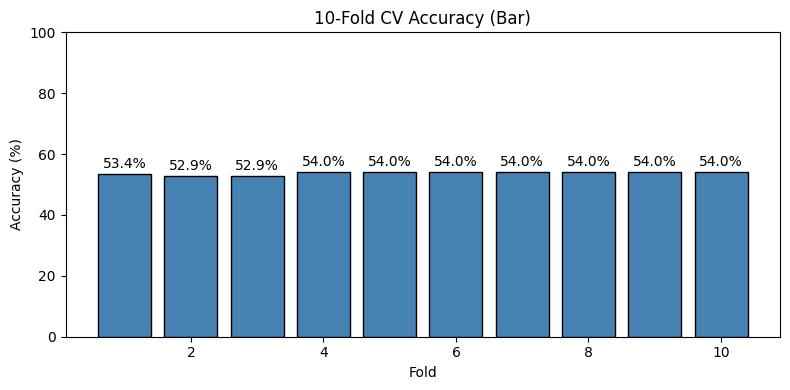

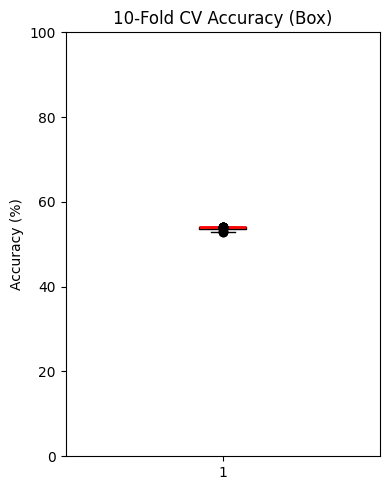

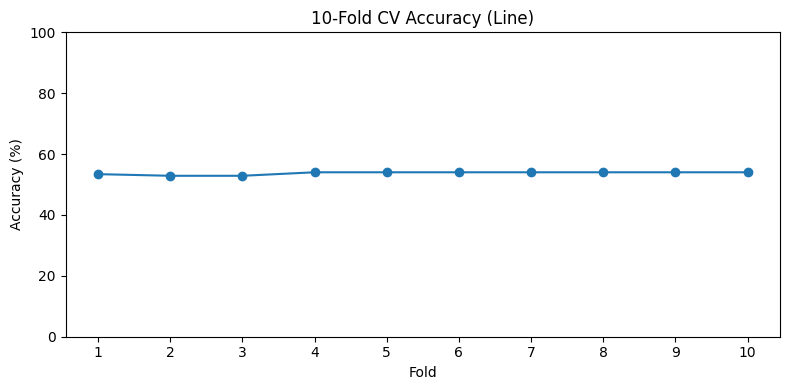

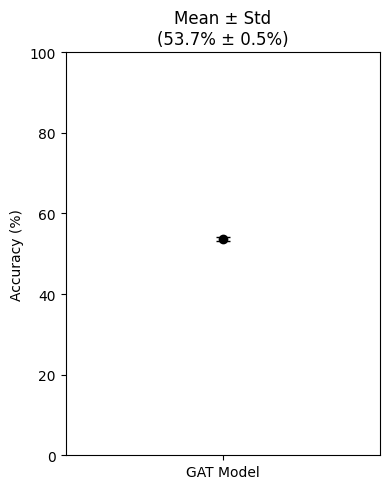

In [1]:
# Top 100 without inner split
import numpy as np
import torch
from torch_geometric.data import Data, DataLoader
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, global_mean_pool
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

# Define model
class GraphAttentionModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=4):
        super(GraphAttentionModel, self).__init__()
        self.gat1 = GATv2Conv(input_dim, hidden_dim, heads=heads, dropout=0.3, edge_dim=1)
        self.gat2 = GATv2Conv(hidden_dim * heads, hidden_dim, heads=heads, dropout=0.3, edge_dim=1)
        self.gat3 = GATv2Conv(hidden_dim * heads, output_dim, heads=1, concat=False, dropout=0.3, edge_dim=1)
        self.fc = torch.nn.Linear(output_dim, 1)

    def forward(self, x, edge_index, edge_weight, batch):
        ew = edge_weight.view(-1, 1)
        x = F.relu(self.gat1(x, edge_index, ew))
        x = F.relu(self.gat2(x, edge_index, ew))
        x = self.gat3(x, edge_index, ew)
        x = global_mean_pool(x, batch)
        return torch.sigmoid(self.fc(x))

# Training function
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_weight, data.batch)
        loss = criterion(out.squeeze(1), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluation accuracy
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.edge_weight, data.batch)
            pred = (out.squeeze(1) > 0.5).float()
            correct += (pred == data.y).sum().item()
            total += data.num_graphs
    return correct / total

# Load data
x = np.load('./data/BASC-444_tangent_correlation.npy')  # shape: (871, 116, 116)
y = np.load('./data/Y.npy')  # shape: (871,)

accuracy_vector = np.load("./basc444/accuracy_vector_basc444(500t-tangent).npy")
selected_indices = np.load("./basc444/selected_indices_basc444(500t-tangent).npy")

# Select top edges from best trial
top_n = 100
best_trial_index = np.argmax(accuracy_vector)
best_selected_indices = selected_indices[:top_n, best_trial_index]

print("Best trial index:", best_trial_index)
print("Best accuracy:", accuracy_vector[best_trial_index])

num_graphs, num_nodes, _ = x.shape
edge_pairs = [(i, j) for i in range(num_nodes) for j in range(i + 1, num_nodes)]

# Generate graphs using only selected edges
def generate_selected_graphs(X, y, selected_edge_indices):
    graphs = []
    for graph_idx in range(X.shape[0]):
        adjacency_matrix = X[graph_idx]
        label = y[graph_idx]
        node_features = [[1.0] for _ in range(num_nodes)]
        edge_index = []
        edge_weight = []

        for idx in selected_edge_indices:
            i, j = edge_pairs[idx]
            w = adjacency_matrix[i, j]
            if w != 0:
                edge_index.append([i, j])
                edge_weight.append(w)
                node_features[i][0] += w
                node_features[j][0] += w

        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous() \
                     if edge_index else torch.empty((2, 0), dtype=torch.long)
        edge_weight = torch.tensor(edge_weight, dtype=torch.float)
        node_features = torch.tensor(node_features, dtype=torch.float)
        label_tensor = torch.tensor(label, dtype=torch.float)

        graphs.append(Data(x=node_features,
                           edge_index=edge_index,
                           edge_weight=edge_weight,
                           y=label_tensor))
    return graphs

selected_graphs = generate_selected_graphs(x, y, best_selected_indices)
graph_labels = y

# Stratified 10-Fold CV (no inner split)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
test_accuracies = []

for fold, (train_idx, test_idx) in enumerate(skf.split(selected_graphs, graph_labels), 1):
    train_loader = DataLoader([selected_graphs[i] for i in train_idx], batch_size=32, shuffle=True)
    test_loader  = DataLoader([selected_graphs[i] for i in test_idx],  batch_size=32)

    model = GraphAttentionModel(input_dim=1, hidden_dim=16, output_dim=2, heads=4)
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(30):
        _ = train(model, train_loader, optimizer, criterion)

    acc = evaluate(model, test_loader)
    test_accuracies.append(acc)
    print(f"Fold {fold}: Test Accuracy = {acc:.4f}")

mean_acc = np.mean(test_accuracies)
std_acc = np.std(test_accuracies)
print(f"\nAverage Test Accuracy over 10 folds: {mean_acc:.4f} ± {std_acc:.4f}")

# ------------------------
# Visualization of results
# ------------------------

# Convert to percent
accuracies = np.array(test_accuracies) * 100
folds = np.arange(1, len(accuracies) + 1)

# 1) Bar Plot
plt.figure(figsize=(8,4))
bars = plt.bar(folds, accuracies, color='steelblue', edgecolor='black')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.title('10-Fold CV Accuracy (Bar)')
plt.ylim(0, 100)
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x()+bar.get_width()/2, h+1, f'{h:.1f}%', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# 2) Box Plot
plt.figure(figsize=(4,5))
plt.boxplot(accuracies,
            vert=True,
            patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='black'),
            medianprops=dict(color='red', linewidth=2),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'))
plt.scatter(np.ones_like(accuracies), accuracies, color='black', zorder=3)
plt.ylabel('Accuracy (%)')
plt.title('10-Fold CV Accuracy (Box)')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# 3) Line Plot
plt.figure(figsize=(8,4))
plt.plot(folds, accuracies, marker='o', linestyle='-')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.title('10-Fold CV Accuracy (Line)')
plt.xticks(folds)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# 4) Error-Bar Plot
mean_p = accuracies.mean()
std_p = accuracies.std()
plt.figure(figsize=(4,5))
plt.errorbar(1, mean_p, yerr=std_p, fmt='o', capsize=5, color='black')
plt.xlim(0.5, 1.5)
plt.xticks([1], ['GAT Model'])
plt.ylabel('Accuracy (%)')
plt.title(f'Mean ± Std\n({mean_p:.1f}% ± {std_p:.1f}%)')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

In [6]:
# All edges without inner split
import numpy as np
import torch
from torch_geometric.data import Data, DataLoader
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, global_mean_pool
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

# Define model
class GraphAttentionModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=4):
        super(GraphAttentionModel, self).__init__()
        self.gat1 = GATv2Conv(input_dim, hidden_dim, heads=heads, dropout=0.3, edge_dim=1)
        self.gat2 = GATv2Conv(hidden_dim * heads, hidden_dim, heads=heads, dropout=0.3, edge_dim=1)
        self.gat3 = GATv2Conv(hidden_dim * heads, output_dim, heads=1, concat=False, dropout=0.3, edge_dim=1)
        self.fc = torch.nn.Linear(output_dim, 1)

    def forward(self, x, edge_index, edge_weight, batch):
        ew = edge_weight.view(-1, 1)
        x = F.relu(self.gat1(x, edge_index, ew))
        x = F.relu(self.gat2(x, edge_index, ew))
        x = self.gat3(x, edge_index, ew)
        x = global_mean_pool(x, batch)
        return torch.sigmoid(self.fc(x))

# Training function
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_weight, data.batch)
        loss = criterion(out.squeeze(1), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluation accuracy
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.edge_weight, data.batch)
            pred = (out.squeeze(1) > 0.5).float()
            correct += (pred == data.y).sum().item()
            total += data.num_graphs
    return correct / total

# Load data
x = np.load('./data/BASC-444_tangent_correlation.npy')  # shape: (871, 116, 116)
y = np.load('./data/Y.npy')  # shape: (871,)

accuracy_vector = np.load("./basc444/accuracy_vector_basc444(500t-tangent).npy")
selected_indices = np.load("./basc444/selected_indices_basc444(500t-tangent).npy")

# Select top edges from best trial

best_trial_index = np.argmax(accuracy_vector)
best_selected_indices = selected_indices[:, best_trial_index]

print("Best trial index:", best_trial_index)
print("Best accuracy:", accuracy_vector[best_trial_index])

num_graphs, num_nodes, _ = x.shape
edge_pairs = [(i, j) for i in range(num_nodes) for j in range(i + 1, num_nodes)]

# Generate graphs using only selected edges
def generate_selected_graphs(X, y, selected_edge_indices):
    graphs = []
    for graph_idx in range(X.shape[0]):
        adjacency_matrix = X[graph_idx]
        label = y[graph_idx]
        node_features = [[1.0] for _ in range(num_nodes)]
        edge_index = []
        edge_weight = []

        for idx in selected_edge_indices:
            i, j = edge_pairs[idx]
            w = adjacency_matrix[i, j]
            if w != 0:
                edge_index.append([i, j])
                edge_weight.append(w)
                node_features[i][0] += w
                node_features[j][0] += w

        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous() \
                     if edge_index else torch.empty((2, 0), dtype=torch.long)
        edge_weight = torch.tensor(edge_weight, dtype=torch.float)
        node_features = torch.tensor(node_features, dtype=torch.float)
        label_tensor = torch.tensor(label, dtype=torch.float)

        graphs.append(Data(x=node_features,
                           edge_index=edge_index,
                           edge_weight=edge_weight,
                           y=label_tensor))
    return graphs

selected_graphs = generate_selected_graphs(x, y, best_selected_indices)
graph_labels = y

# Stratified 10-Fold CV (no inner split)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
test_accuracies = []

for fold, (train_idx, test_idx) in enumerate(skf.split(selected_graphs, graph_labels), 1):
    train_loader = DataLoader([selected_graphs[i] for i in train_idx], batch_size=32, shuffle=True)
    test_loader  = DataLoader([selected_graphs[i] for i in test_idx],  batch_size=32)

    model = GraphAttentionModel(input_dim=1, hidden_dim=16, output_dim=2, heads=4)
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(30):
        _ = train(model, train_loader, optimizer, criterion)

    acc = evaluate(model, test_loader)
    test_accuracies.append(acc)
    print(f"Fold {fold}: Test Accuracy = {acc:.4f}")

mean_acc = np.mean(test_accuracies)
std_acc = np.std(test_accuracies)
print(f"\nAverage Test Accuracy over 10 folds: {mean_acc:.4f} ± {std_acc:.4f}")

# # ------------------------
# # Visualization of results
# # ------------------------

# # Convert to percent
# accuracies = np.array(test_accuracies) * 100
# folds = np.arange(1, len(accuracies) + 1)

# # 1) Bar Plot
# plt.figure(figsize=(8,4))
# bars = plt.bar(folds, accuracies, color='steelblue', edgecolor='black')
# plt.xlabel('Fold')
# plt.ylabel('Accuracy (%)')
# plt.title('10-Fold CV Accuracy (Bar)')
# plt.ylim(0, 100)
# for bar in bars:
#     h = bar.get_height()
#     plt.text(bar.get_x()+bar.get_width()/2, h+1, f'{h:.1f}%', ha='center', va='bottom')
# plt.tight_layout()
# plt.show()

# # 2) Box Plot
# plt.figure(figsize=(4,5))
# plt.boxplot(accuracies,
#             vert=True,
#             patch_artist=True,
#             boxprops=dict(facecolor='lightblue', color='black'),
#             medianprops=dict(color='red', linewidth=2),
#             whiskerprops=dict(color='black'),
#             capprops=dict(color='black'))
# plt.scatter(np.ones_like(accuracies), accuracies, color='black', zorder=3)
# plt.ylabel('Accuracy (%)')
# plt.title('10-Fold CV Accuracy (Box)')
# plt.ylim(0, 100)
# plt.tight_layout()
# plt.show()

# # 3) Line Plot
# plt.figure(figsize=(8,4))
# plt.plot(folds, accuracies, marker='o', linestyle='-')
# plt.xlabel('Fold')
# plt.ylabel('Accuracy (%)')
# plt.title('10-Fold CV Accuracy (Line)')
# plt.xticks(folds)
# plt.ylim(0, 100)
# plt.tight_layout()
# plt.show()

# # 4) Error-Bar Plot
# mean_p = accuracies.mean()
# std_p = accuracies.std()
# plt.figure(figsize=(4,5))
# plt.errorbar(1, mean_p, yerr=std_p, fmt='o', capsize=5, color='black')
# plt.xlim(0.5, 1.5)
# plt.xticks([1], ['GAT Model'])
# plt.ylabel('Accuracy (%)')
# plt.title(f'Mean ± Std\n({mean_p:.1f}% ± {std_p:.1f}%)')
# plt.ylim(0, 100)
# plt.tight_layout()
# plt.show()

Best trial index: 43
Best accuracy: 0.7045454545454546


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold 1: Test Accuracy = 0.5341
Fold 2: Test Accuracy = 0.5287
Fold 3: Test Accuracy = 0.5287
Fold 4: Test Accuracy = 0.5402
Fold 5: Test Accuracy = 0.5402
Fold 6: Test Accuracy = 0.5402
Fold 7: Test Accuracy = 0.5402
Fold 8: Test Accuracy = 0.5402
Fold 9: Test Accuracy = 0.5402
Fold 10: Test Accuracy = 0.5402

Average Test Accuracy over 10 folds: 0.5373 ± 0.0047


In [5]:
# Trying with Grid Search ( Top 100 without inner split)
import numpy as np
import torch
from torch_geometric.data import Data, DataLoader
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, global_mean_pool
from sklearn.model_selection import StratifiedKFold

# Define model with configurable dropout
class GraphAttentionModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=4, dropout=0.3):
        super().__init__()
        self.gat1 = GATv2Conv(input_dim, hidden_dim, heads=heads,
                              dropout=dropout, edge_dim=1)
        self.gat2 = GATv2Conv(hidden_dim * heads, hidden_dim, heads=heads,
                              dropout=dropout, edge_dim=1)
        self.gat3 = GATv2Conv(hidden_dim * heads, output_dim, heads=1,
                              concat=False, dropout=dropout, edge_dim=1)
        self.fc   = torch.nn.Linear(output_dim, 1)

    def forward(self, x, edge_index, edge_weight, batch):
        ew = edge_weight.view(-1, 1)
        x = F.relu(self.gat1(x, edge_index, ew))
        x = F.relu(self.gat2(x, edge_index, ew))
        x = self.gat3(x, edge_index, ew)
        x = global_mean_pool(x, batch)
        return torch.sigmoid(self.fc(x))

def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_weight, data.batch)
        loss = criterion(out.squeeze(1), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.edge_weight, data.batch)
            pred = (out.squeeze(1) > 0.5).float()
            correct += (pred == data.y).sum().item()
            total += data.num_graphs
    return correct / total

# Load data and pre-selected edges
x = np.load('./data/BASC-444_tangent_correlation.npy')
y = np.load('./data/Y.npy')
accuracy_vector   = np.load('./basc444/accuracy_vector_basc444(500t-tangent).npy')
selected_indices  = np.load('./basc444/selected_indices_basc444(500t-tangent).npy')

top_n=100
best_trial_index  = np.argmax(accuracy_vector)
best_selected_edges = selected_indices[:top_n, best_trial_index]
print("Using best mask from trial", best_trial_index,
      "with accuracy", accuracy_vector[best_trial_index])

num_graphs, num_nodes, _ = x.shape
edge_pairs = [(i, j) for i in range(num_nodes) for j in range(i + 1, num_nodes)]

def generate_selected_graphs(X, y, selected_edge_indices):
    graphs = []
    for graph_idx in range(X.shape[0]):
        A      = X[graph_idx]
        label  = y[graph_idx]
        node_features = [[1.0] for _ in range(num_nodes)]
        edge_index, edge_weight = [], []
        for idx in selected_edge_indices:
            i, j = edge_pairs[idx]
            w = A[i, j]
            if w != 0:
                edge_index.append([i, j])
                edge_weight.append(w)
                node_features[i][0] += w
                node_features[j][0] += w
        edge_index = (torch.tensor(edge_index, dtype=torch.long)
                          .t().contiguous()
                      if edge_index
                      else torch.empty((2, 0), dtype=torch.long))
        edge_weight    = torch.tensor(edge_weight, dtype=torch.float)
        node_features  = torch.tensor(node_features, dtype=torch.float)
        label_tensor   = torch.tensor(label, dtype=torch.float)
        graphs.append(Data(x=node_features,
                           edge_index=edge_index,
                           edge_weight=edge_weight,
                           y=label_tensor))
    return graphs

# Pre-generate once
selected_graphs = generate_selected_graphs(x, y, best_selected_edges)
labels = y

# Hyperparameter grid
dropouts      = [0.3, 0.5, 0.7]
lrs           = [1e-3, 1e-4]
weight_decays = [1e-4, 1e-3]

best_mean_acc = 0.0
best_std_acc  = 0.0
best_config   = {}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Grid search over dropout, lr, weight_decay
for dropout in dropouts:
    for lr in lrs:
        for wd in weight_decays:
            print(f"\nTesting config: dropout={dropout}, lr={lr}, weight_decay={wd}")
            test_accuracies = []
            for fold, (train_idx, test_idx) in enumerate(skf.split(selected_graphs, labels), 1):
                train_loader = DataLoader([selected_graphs[i] for i in train_idx],
                                          batch_size=32, shuffle=True)
                test_loader  = DataLoader([selected_graphs[i] for i in test_idx],
                                          batch_size=32)

                model     = GraphAttentionModel(input_dim=1,
                                                hidden_dim=16,
                                                output_dim=2,
                                                heads=4,
                                                dropout=dropout)
                criterion = torch.nn.BCELoss()
                optimizer = torch.optim.Adam(model.parameters(),
                                             lr=lr,
                                             weight_decay=wd)

                for epoch in range(30):
                    _ = train(model, train_loader, optimizer, criterion)

                acc = evaluate(model, test_loader)
                test_accuracies.append(acc)
                print(f"Fold {fold}: Test Acc = {acc:.4f}")

            mean_acc = np.mean(test_accuracies)
            std_acc  = np.std(test_accuracies)
            print(f"--> Mean CV Acc: {mean_acc:.4f} ± {std_acc:.4f}")

            if mean_acc > best_mean_acc:
                best_mean_acc = mean_acc
                best_std_acc  = std_acc
                best_config   = {'dropout': dropout, 'lr': lr, 'weight_decay': wd}

# Report best hyperparameters
print(f"\nBest config: {best_config}, CV accuracy = {best_mean_acc:.4f} ± {best_std_acc:.4f}")

Using best mask from trial 43 with accuracy 0.7045454545454546

Testing config: dropout=0.3, lr=0.001, weight_decay=0.0001


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold 1: Test Acc = 0.5341
Fold 2: Test Acc = 0.5287
Fold 3: Test Acc = 0.5287
Fold 4: Test Acc = 0.5402
Fold 5: Test Acc = 0.5402
Fold 6: Test Acc = 0.5402
Fold 7: Test Acc = 0.5402
Fold 8: Test Acc = 0.5402
Fold 9: Test Acc = 0.5402
Fold 10: Test Acc = 0.5402
--> Mean CV Acc: 0.5373 ± 0.0047

Testing config: dropout=0.3, lr=0.001, weight_decay=0.001


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold 1: Test Acc = 0.5341
Fold 2: Test Acc = 0.5287
Fold 3: Test Acc = 0.5287
Fold 4: Test Acc = 0.5402
Fold 5: Test Acc = 0.5402
Fold 6: Test Acc = 0.5402
Fold 7: Test Acc = 0.5402
Fold 8: Test Acc = 0.5402
Fold 9: Test Acc = 0.5402
Fold 10: Test Acc = 0.5402
--> Mean CV Acc: 0.5373 ± 0.0047

Testing config: dropout=0.3, lr=0.0001, weight_decay=0.0001


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold 1: Test Acc = 0.5341
Fold 2: Test Acc = 0.5287
Fold 3: Test Acc = 0.5287
Fold 4: Test Acc = 0.5402
Fold 5: Test Acc = 0.5402
Fold 6: Test Acc = 0.5402
Fold 7: Test Acc = 0.5402
Fold 8: Test Acc = 0.5402
Fold 9: Test Acc = 0.5402
Fold 10: Test Acc = 0.5402
--> Mean CV Acc: 0.5373 ± 0.0047

Testing config: dropout=0.3, lr=0.0001, weight_decay=0.001


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold 1: Test Acc = 0.5341
Fold 2: Test Acc = 0.5287
Fold 3: Test Acc = 0.5287
Fold 4: Test Acc = 0.5402
Fold 5: Test Acc = 0.5402
Fold 6: Test Acc = 0.5402
Fold 7: Test Acc = 0.5402
Fold 8: Test Acc = 0.5402
Fold 9: Test Acc = 0.5402
Fold 10: Test Acc = 0.5402
--> Mean CV Acc: 0.5373 ± 0.0047

Testing config: dropout=0.5, lr=0.001, weight_decay=0.0001


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold 1: Test Acc = 0.5341
Fold 2: Test Acc = 0.5287
Fold 3: Test Acc = 0.5287
Fold 4: Test Acc = 0.5402
Fold 5: Test Acc = 0.5402
Fold 6: Test Acc = 0.5402
Fold 7: Test Acc = 0.4598
Fold 8: Test Acc = 0.5402
Fold 9: Test Acc = 0.5402
Fold 10: Test Acc = 0.5402
--> Mean CV Acc: 0.5293 ± 0.0236

Testing config: dropout=0.5, lr=0.001, weight_decay=0.001


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold 1: Test Acc = 0.5341
Fold 2: Test Acc = 0.5287
Fold 3: Test Acc = 0.5287
Fold 4: Test Acc = 0.5402
Fold 5: Test Acc = 0.5402
Fold 6: Test Acc = 0.5402
Fold 7: Test Acc = 0.5402
Fold 8: Test Acc = 0.5402
Fold 9: Test Acc = 0.5402
Fold 10: Test Acc = 0.5402
--> Mean CV Acc: 0.5373 ± 0.0047

Testing config: dropout=0.5, lr=0.0001, weight_decay=0.0001


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold 1: Test Acc = 0.5341
Fold 2: Test Acc = 0.5287
Fold 3: Test Acc = 0.5287
Fold 4: Test Acc = 0.5402
Fold 5: Test Acc = 0.5402
Fold 6: Test Acc = 0.5402
Fold 7: Test Acc = 0.5402
Fold 8: Test Acc = 0.5402
Fold 9: Test Acc = 0.5402
Fold 10: Test Acc = 0.5402
--> Mean CV Acc: 0.5373 ± 0.0047

Testing config: dropout=0.5, lr=0.0001, weight_decay=0.001


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold 1: Test Acc = 0.5341
Fold 2: Test Acc = 0.5287
Fold 3: Test Acc = 0.5287
Fold 4: Test Acc = 0.5402
Fold 5: Test Acc = 0.5402
Fold 6: Test Acc = 0.5402
Fold 7: Test Acc = 0.5402
Fold 8: Test Acc = 0.5402
Fold 9: Test Acc = 0.5402
Fold 10: Test Acc = 0.5402
--> Mean CV Acc: 0.5373 ± 0.0047

Testing config: dropout=0.7, lr=0.001, weight_decay=0.0001


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold 1: Test Acc = 0.5341
Fold 2: Test Acc = 0.4713
Fold 3: Test Acc = 0.5287
Fold 4: Test Acc = 0.5402
Fold 5: Test Acc = 0.5402
Fold 6: Test Acc = 0.4598
Fold 7: Test Acc = 0.4598
Fold 8: Test Acc = 0.5402
Fold 9: Test Acc = 0.4598
Fold 10: Test Acc = 0.5402
--> Mean CV Acc: 0.5074 ± 0.0369

Testing config: dropout=0.7, lr=0.001, weight_decay=0.001


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold 1: Test Acc = 0.5341
Fold 2: Test Acc = 0.5287
Fold 3: Test Acc = 0.5287
Fold 4: Test Acc = 0.5402
Fold 5: Test Acc = 0.5402
Fold 6: Test Acc = 0.5402
Fold 7: Test Acc = 0.5402
Fold 8: Test Acc = 0.5402
Fold 9: Test Acc = 0.5402
Fold 10: Test Acc = 0.5402
--> Mean CV Acc: 0.5373 ± 0.0047

Testing config: dropout=0.7, lr=0.0001, weight_decay=0.0001


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold 1: Test Acc = 0.5341
Fold 2: Test Acc = 0.4713
Fold 3: Test Acc = 0.5287
Fold 4: Test Acc = 0.5402
Fold 5: Test Acc = 0.5402
Fold 6: Test Acc = 0.5402
Fold 7: Test Acc = 0.5402
Fold 8: Test Acc = 0.5402
Fold 9: Test Acc = 0.5402
Fold 10: Test Acc = 0.5402
--> Mean CV Acc: 0.5316 ± 0.0204

Testing config: dropout=0.7, lr=0.0001, weight_decay=0.001


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold 1: Test Acc = 0.5341
Fold 2: Test Acc = 0.5287
Fold 3: Test Acc = 0.5287
Fold 4: Test Acc = 0.5402
Fold 5: Test Acc = 0.5402
Fold 6: Test Acc = 0.5402
Fold 7: Test Acc = 0.5402
Fold 8: Test Acc = 0.5402
Fold 9: Test Acc = 0.5402
Fold 10: Test Acc = 0.5402
--> Mean CV Acc: 0.5373 ± 0.0047

Best config: {'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.0001}, CV accuracy = 0.5373 ± 0.0047


In [5]:
import numpy as np

# Load your arrays
selected_indices = np.load('./data2/selected_indices_basc444(500t-tangent).npy')
accuracy_vector = np.load('./data2/accuracy_vector_basc444(500t-tangent).npy')

# Get sorted indices of the accuracies (descending)
sorted_indices = np.argsort(accuracy_vector)[::-1]

# Top 2 trials
top2_indices = sorted_indices[:2]

# Bottom 2 trials
bottom2_indices = sorted_indices[-2:]

print("Top 2 trial indices:", top2_indices)
print("Top 2 accuracies:", accuracy_vector[top2_indices])

print("Bottom 2 trial indices:", bottom2_indices)
print("Bottom 2 accuracies:", accuracy_vector[bottom2_indices])

# If you want to see the selected edges for the top/bottom trials:
top2_selected_edges = selected_indices[:, top2_indices]
bottom2_selected_edges = selected_indices[:, bottom2_indices]

# For example, first 5 edges of the best trial:
print("First 5 selected edges of best trial:", top2_selected_edges[:5,0])


Top 2 trial indices: [ 43 127]
Top 2 accuracies: [0.70454545 0.65909091]
Bottom 2 trial indices: [360   4]
Bottom 2 accuracies: [0.42045455 0.375     ]
First 5 selected edges of best trial: [13016 95428 41022  5686 28820]
